In [7]:
import os

# Set the directory
os.chdir('/Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT')

# Verify the change
print(os.getcwd())


/Users/ajibolaoluwatobiloba/Desktop/NHL ASSIGNMENT


In [11]:
import numpy as np
import datetime
import cmdstanpy
import pandas as pd
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()
plt.style.use('ggplot')

# Read the data
df = pd.read_csv('model_inputs.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Get season from game_id (first 4 digits)
df['season'] = df['game_id'].astype(str).str[:4].astype(int)

# Create a copy for the season data to avoid SettingWithCopyWarning
df_season = df[df['season'] == 2023].copy()

# Create team indices (adding 1 for Stan's 1-based indexing)
home_inds, teams = pd.factorize(df_season['hm_team'], sort=True)
away_inds, _ = pd.factorize(df_season['aw_team'], sort=True)
df_season.loc[:, 'home_inds'] = home_inds + 1
df_season.loc[:, 'away_inds'] = away_inds + 1

print("Number of games in season:", len(df_season))
print("\nNumber of teams:", len(teams))
print("\nTeams:", teams.tolist())

# Print some statistics to verify data
print("\nSummary statistics:")
print(f"Average home goals: {df_season['home_total_goals'].mean():.2f}")
print(f"Average away goals: {df_season['away_total_goals'].mean():.2f}")
print(f"Number of b2b games (home): {df_season['hm_is_b2b'].sum()}")
print(f"Number of b2b games (away): {df_season['aw_is_b2b'].sum()}")

# Prepare data for Stan
data = {
    'N': len(df_season),
    'n_teams': len(teams),
    'home_team': df_season['home_inds'].values,
    'away_team': df_season['away_inds'].values,
    'home_total_goals': df_season['home_total_goals'].values,
    'away_total_goals': df_season['away_total_goals'].values,
    'home_b2b': df_season['hm_is_b2b'].values,
    'away_b2b': df_season['aw_is_b2b'].values
}

# Initial values as dictionaries
init_values_orig = [
    {
        'sigma': 0.1,
        'alpha': 1.0,
        'p_ha': 0.1,
        'team_off': list(np.random.normal(0, 0.1, len(teams))),
        'team_def': list(np.random.normal(0, 0.1, len(teams)))
    } for _ in range(4)  # One for each chain
]

init_values_b2b = [
    {
        'sigma': 0.1,
        'alpha': 1.0,
        'p_ha': 0.1,
        'b2b_effect': -0.05,
        'team_off': list(np.random.normal(0, 0.1, len(teams))),
        'team_def': list(np.random.normal(0, 0.1, len(teams)))
    } for _ in range(4)  # One for each chain
]

# Fit original model
model_orig = CmdStanModel(stan_file='bayes_hockey_example.stan')
fit_orig = model_orig.sample(
    data={k: v for k, v in data.items() if k not in ['home_b2b', 'away_b2b']},
    chains=4,
    inits=init_values_orig,
    iter_warmup=1000,
    iter_sampling=1000
)

# Fit b2b model
model_b2b = CmdStanModel(stan_file='stan-model-b2b.stan')
fit_b2b = model_b2b.sample(
    data=data,
    chains=4,
    inits=init_values_b2b,
    iter_warmup=1000,
    iter_sampling=1000
)

# Print diagnostics
print("\nOriginal Model Diagnostics:")
print(fit_orig.diagnose())
print("\nB2B Model Diagnostics:")
print(fit_b2b.diagnose())

# Summary of parameters
print("\nOriginal Model Summary:")
print(fit_orig.summary())

16:12:05 - cmdstanpy - INFO - CmdStan start processing


Number of games in season: 1292

Number of teams: 32

Teams: ['ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL', 'DAL', 'DET', 'EDM', 'FLA', 'LAK', 'MIN', 'MTL', 'NJD', 'NSH', 'NYI', 'NYR', 'OTT', 'PHI', 'PIT', 'SEA', 'SJS', 'STL', 'TBL', 'TOR', 'VAN', 'VGK', 'WPG', 'WSH']

Summary statistics:
Average home goals: 3.22
Average away goals: 3.00
Number of b2b games (home): 119
Number of b2b games (away): 235


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:10 - cmdstanpy - INFO - CmdStan done processing.


16:12:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:16 - cmdstanpy - INFO - CmdStan done processing.




Original Model Diagnostics:
Processing csv files: /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpfgv1abcb/bayes_hockey_examplemrw_0ais/bayes_hockey_example-20241124161205_1.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpfgv1abcb/bayes_hockey_examplemrw_0ais/bayes_hockey_example-20241124161205_2.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpfgv1abcb/bayes_hockey_examplemrw_0ais/bayes_hockey_example-20241124161205_3.csv, /var/folders/2g/jqy8zbqj43g1g1t7rhb5xl9h0000gn/T/tmpfgv1abcb/bayes_hockey_examplemrw_0ais/bayes_hockey_example-20241124161205_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


B2B Model Diagnostics:
Processing csv f

In [ ]:
# Analysis & Comparison of both  models


Back-to-back Effect Summary:
Mean B2B effect: -0.0618
Standard deviation: 0.0276
95% Credible Interval: [-0.1168, -0.0068]

Home Advantage Effect:
Original model: 0.0398 ± 0.0098
B2B model: 0.0379 ± 0.0097


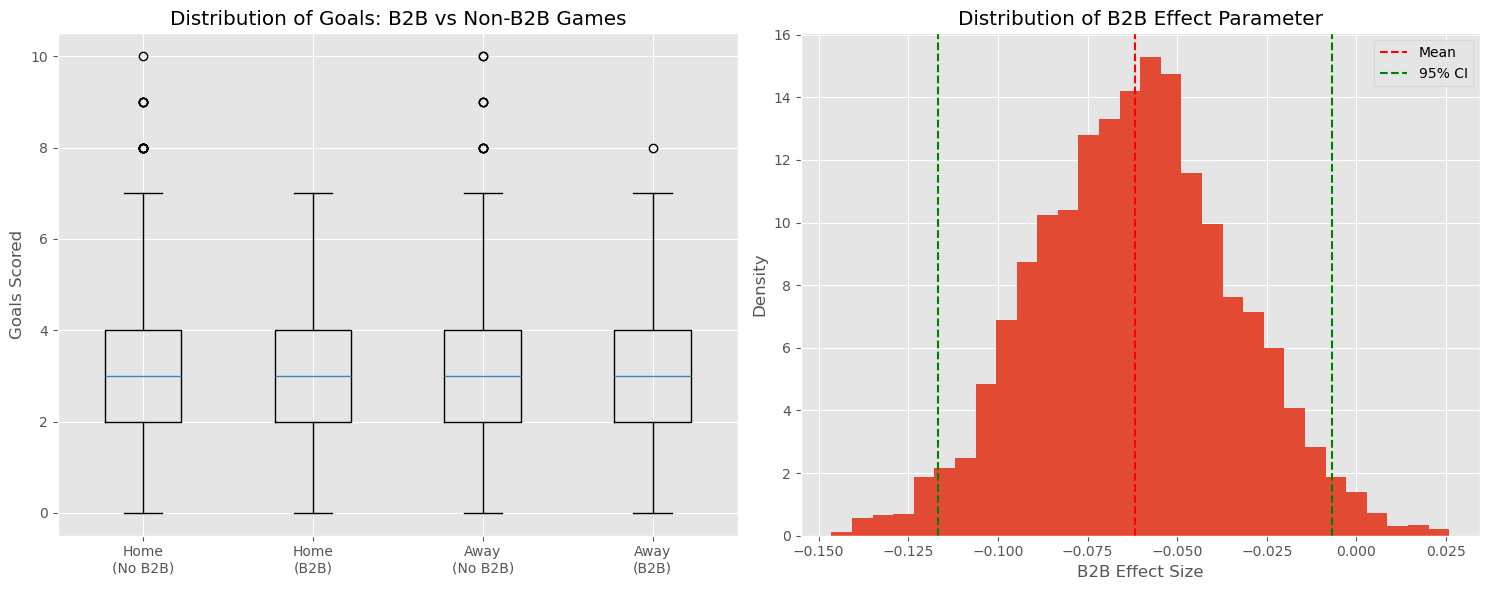


Actual Goal Averages:
Home games without B2B: 3.241
Home games with B2B: 3.050
Away games without B2B: 3.013
Away games with B2B: 2.923

Model Predictions (Mean Rates):
Original model - Home: 3.233, Away: 2.987
B2B model - Home: 3.236, Away: 2.985

Model Performance (RMSE):
Original model - Home: 1.703, Away: 1.715
B2B model - Home: 1.679, Away: 1.701


In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the b2b effect parameter
print("\nBack-to-back Effect Summary:")
b2b_effect = fit_b2b.stan_variable('b2b_effect')
print(f"Mean B2B effect: {np.mean(b2b_effect):.4f}")
print(f"Standard deviation: {np.std(b2b_effect):.4f}")
print(f"95% Credible Interval: [{np.percentile(b2b_effect, 2.5):.4f}, {np.percentile(b2b_effect, 97.5):.4f}]")

# Get home advantage parameter from both models
p_ha_orig = fit_orig.stan_variable('p_ha')
p_ha_b2b = fit_b2b.stan_variable('p_ha')
print("\nHome Advantage Effect:")
print(f"Original model: {np.mean(p_ha_orig):.4f} ± {np.std(p_ha_orig):.4f}")
print(f"B2B model: {np.mean(p_ha_b2b):.4f} ± {np.std(p_ha_b2b):.4f}")

# Create figure with three subplots
plt.figure(figsize=(15, 6))

# Plot 1: Distribution of goals with and without b2b
plt.subplot(1, 2, 1)
data_to_plot = [
    df_season[df_season['hm_is_b2b'] == 0]['home_total_goals'],
    df_season[df_season['hm_is_b2b'] == 1]['home_total_goals'],
    df_season[df_season['aw_is_b2b'] == 0]['away_total_goals'],
    df_season[df_season['aw_is_b2b'] == 1]['away_total_goals']
]
plt.boxplot(data_to_plot, labels=['Home\n(No B2B)', 'Home\n(B2B)', 'Away\n(No B2B)', 'Away\n(B2B)'])
plt.title('Distribution of Goals: B2B vs Non-B2B Games')
plt.ylabel('Goals Scored')

# Plot 2: B2B Effect Distribution
plt.subplot(1, 2, 2)
plt.hist(b2b_effect, bins=30, density=True)
plt.axvline(np.mean(b2b_effect), color='r', linestyle='--', label='Mean')
plt.axvline(np.percentile(b2b_effect, 2.5), color='g', linestyle='--', label='95% CI')
plt.axvline(np.percentile(b2b_effect, 97.5), color='g', linestyle='--')
plt.title('Distribution of B2B Effect Parameter')
plt.xlabel('B2B Effect Size')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate average actual goals for b2b vs non-b2b games
print("\nActual Goal Averages:")
print(f"Home games without B2B: {df_season[df_season['hm_is_b2b'] == 0]['home_total_goals'].mean():.3f}")
print(f"Home games with B2B: {df_season[df_season['hm_is_b2b'] == 1]['home_total_goals'].mean():.3f}")
print(f"Away games without B2B: {df_season[df_season['aw_is_b2b'] == 0]['away_total_goals'].mean():.3f}")
print(f"Away games with B2B: {df_season[df_season['aw_is_b2b'] == 1]['away_total_goals'].mean():.3f}")

# Compare model predictions
home_rates_orig = fit_orig.stan_variable('lam_home_rate')
away_rates_orig = fit_orig.stan_variable('lam_away_rate')
home_rates_b2b = fit_b2b.stan_variable('lam_home_rate')
away_rates_b2b = fit_b2b.stan_variable('lam_away_rate')

print("\nModel Predictions (Mean Rates):")
print(f"Original model - Home: {np.mean(home_rates_orig):.3f}, Away: {np.mean(away_rates_orig):.3f}")
print(f"B2B model - Home: {np.mean(home_rates_b2b):.3f}, Away: {np.mean(away_rates_b2b):.3f}")

# Calculate Root Mean Square Error (RMSE) for both models
def calculate_rmse(actual, predicted_rates):
    predicted = np.mean(predicted_rates, axis=0)
    return np.sqrt(np.mean((actual - predicted) ** 2))

rmse_orig_home = calculate_rmse(df_season['home_total_goals'].values, home_rates_orig)
rmse_orig_away = calculate_rmse(df_season['away_total_goals'].values, away_rates_orig)
rmse_b2b_home = calculate_rmse(df_season['home_total_goals'].values, home_rates_b2b)
rmse_b2b_away = calculate_rmse(df_season['away_total_goals'].values, away_rates_b2b)

print("\nModel Performance (RMSE):")
print(f"Original model - Home: {rmse_orig_home:.3f}, Away: {rmse_orig_away:.3f}")
print(f"B2B model - Home: {rmse_b2b_home:.3f}, Away: {rmse_b2b_away:.3f}")